<a href="https://colab.research.google.com/github/rahul13ramesh/cis520-dataset/blob/master/CIS520_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-520 Project -[What's cooking](https://www.kaggle.com/c/whats-cooking-kernels-only)

* This notebook looks at the Kaggle contest *What's cooking*. We tackle a supervised and unsupervised learning problem using this dataset
* The input features are a collection of words and hence NLP techniques are used to build useful features for the downstream task

In [0]:
!pip install pywaffle
!git clone https://github.com/amueller/word_cloud.git
!cd word_cloud && pip install .

     |████████████████████████████████| 532kB 2.8MB/s 
Cloning into 'word_cloud'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 4070 (delta 202), reused 317 (delta 163), pack-reused 3692
Receiving objects: 100% (4070/4070), 77.39 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (2258/2258), done.
Processing /content/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post1+g8217e20-cp36-cp36m-linux_x86_64.whl size=335556 sha256=9c00c26bf318357fd675179f727609e6ca5ed4484c9fc12520d2c8f20d713a7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-qfga3oj6/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


In [0]:
import numpy as np
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import json
import unicodedata
import re
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pywaffle import Waffle

In [0]:
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json

--2019-12-01 17:57:54--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2844086 (2.7M) [text/plain]
Saving to: ‘test.json’

test.json           100%[===================>]   2.71M  --.-KB/s    in 0.1s    

2019-12-01 17:57:55 (26.2 MB/s) - ‘test.json’ saved [2844086/2844086]

--2019-12-01 17:57:56--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12415067 (12M) [text/plain]
Saving 

# Loading dataset
We load the dataset and display a single entry from this dataset

In [0]:
with open("test.json", "r") as f:
    test_data = json.load(f)
with open("train.json", "r") as f:
    train_data = json.load(f)
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)

In [0]:
train_data[0]

# Data analysis and Visualization

The aim of this analysis is as follows:

* Gain an understanding of the dataset, distribution of labels and number of data points. 
* Look for potentially useful features that can help an classifier achieve higher accuracies.
* Look for anamolies in data that need to be handled through data pre-processing and cleaning. 

### Preliminary Understanding of Data

In [0]:
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)
cuisines = train_data_df["cuisine"].unique()
print("Data size: " + str(train_data_df.shape))
print("Numerb of cuisines: ", str(len(cuisines)))

In [0]:
train_data_df.groupby(by='cuisine').count().sort_values(by='ingredients',ascending=False)

In [0]:
print(train_data_df.head())

In [0]:
# Waffle Plot of data distribution
class_data = train_data_df.cuisine.value_counts()
class_data = ((class_data)*100) // class_data.values.sum()
colors = [plt.cm.Spectral(i/float(len(cuisines))) for i in range(len(cuisines))]
np.random.seed(5)
np.random.shuffle(colors)

plt.figure(
    figsize=(10, 12),
    FigureClass=Waffle, 
    rows=6,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 9, 'title':'Class', 'ncol': 2},
    values=class_data.values,
    labels=list(class_data.index),
    colors=colors
)
plt.show()

### Analysis of Recipes

In [0]:
# Get space seperated text of all the ingredients
text = ''
for i in range(train_data_df.shape[0]):
    text = text + " " + ' '.join(train_data_df.iloc[i, 2])

# Get all ingredients as a list (along with cuisine, and number of ingredients for each ingredient)
text_list = []
text_list_cuisine = []
text_list_num = []
for i in range(train_data_df.shape[0]):
    text_list = text_list + train_data_df.iloc[i, 2]
    len_ing = len(train_data_df.iloc[i, 2])
    text_list_cuisine = text_list_cuisine + [train_data_df.iloc[i, 1] for i in range(len_ing)]
    text_list_num = text_list_num + [len_ing for i in range(len_ing)]

In [0]:
def get_ingredients(cuisine_val):
    """
    Get all the ingredients for a particular cuisine
    """
    text = ''
    for i in range(train_data_df.shape[0]):
        if cuisine_val == train_data_df.iloc[i, 1]:
            text = text + " " + ' '.join(train_data_df.iloc[i, 2])
    return text
    
def get_num_ingredients(cuisine_val):
    """
    Get the number of ingredients of each recipe for a particular cuisine
    """
    num = []
    for i in range(train_data_df.shape[0]):
        if cuisine_val == train_data_df.iloc[i, 1]:
            num.append(len(train_data_df.iloc[i,2]))
    return num

def plot_word_cloud(txt, coloc=True):
    """
    Plot the word cloud corresponding to some text
    """
    wordcloud = WordCloud(background_color="white", collocations=coloc).generate(txt)
    plt.figure(figsize = (7, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

We first plot word clouds based on the ingredients to understand the nature of the data

In [0]:
# Plot word cloud for entire data
plot_word_cloud(text,True)

We next look at the word-clouds in a per cuisine granularity. The visualizations show that the key ingredients in a recipes vary significantly with the cuisine

In [0]:
cuisine_ingredients = {}
cuisine_numbers = {}
for c in cuisines:
    cuisine_ingredients[c] = get_ingredients(c)
    cuisine_numbers[c] = get_num_ingredients(c)

In [0]:
plot_word_cloud(cuisine_ingredients['indian'])

In [0]:
plot_word_cloud(cuisine_ingredients['italian'])

In [0]:
plot_word_cloud(cuisine_ingredients['mexican'])

Next we look use Violin-plots (box plots) to understand how  the number of ingredients varies with cuisine. The plots indicate that this feature can be used a useful feature for a classifier.

In [0]:
cuisine_num_array = []
cuisine_val = []
for c in cuisines:
    cuisine_num_array = cuisine_num_array + cuisine_numbers[c]
    cuisine_val = cuisine_val + [c for _ in range(len(cuisine_numbers[c]))]
cuisine_number_df = pd.DataFrame([cuisine_num_array, cuisine_val]).T
cuisine_number_df.columns = ["Number of Ingredients", "Cuisine"]
cuisine_number_df["Number of Ingredients"] = pd.to_numeric(cuisine_number_df["Number of Ingredients"])

plt.figure(figsize=(18,5))
sns.violinplot(x="Cuisine", y="Number of Ingredients", data=cuisine_number_df)

plt.figure(figsize=(18,5))
sns.violinplot(x="Cuisine", y="Number of Ingredients", data=cuisine_number_df[cuisine_number_df["Number of Ingredients"] <= 25])
plt.show()

In [0]:
long_ingredients = []
small_ingredients1 = []
small_ingredients2 = []
small_ingredients3 = []
for i in range(train_data_df.shape[0]):
    ing =  train_data_df.iloc[i, 2]
    if len(ing) >= 30:
        long_ingredients.append((ing, train_data_df.iloc[i, 1]))
    elif len(ing) == 1:
        small_ingredients1.append((ing, train_data_df.iloc[i, 1]))
    elif len(ing) == 2:
        small_ingredients2.append((ing, train_data_df.iloc[i, 1]))
    elif len(ing) == 3:
        small_ingredients3.append((ing, train_data_df.iloc[i, 1]))

In [0]:
print("Number of long ingredients: " + str(len(long_ingredients)))
print("Number of short ingredients: " + str(len(small_ingredients1)))
print("Number of short ingredients: " + str(len(small_ingredients2)))
print("Number of short ingredients: " + str(len(small_ingredients3)))

In [0]:
small_ingredients1
# Remove elements with just 1 ingredients, clearly

In [0]:
small_ingredients2[0:5]

In [0]:
small_ingredients3[0:5]

In [0]:
print(long_ingredients[0])

### Understanding Individual Ingredient / Tokens

In [0]:
text_analysis = text.lower()
# Remove elements
rem_elems = ["lb.", "oz.", "inch", "%", "™", "®",  "€", "(", ")", ","]
for e in rem_elems:
    text_analysis = text_analysis.replace(e, " ")
text_analysis = text_analysis.replace("’", "'")
text_analysis = ''.join([i for i in text_analysis if not i.isdigit()])
ing_analysis = text_analysis.split()

In [0]:
word_counts = []
print("Number of Ingredients: " + str(len(set(ing_analysis))))
for x in set(ing_analysis):
    word_counts.append((ing_analysis.count(x), x))

In [0]:
sorted(word_counts, reverse=True)[0:10]

In [0]:
ing_count_df = pd.DataFrame(word_counts)
ing_count_df.columns = ["Count", "Ingredient"]

In [0]:
sns.countplot(data=ing_count_df[ing_count_df.Count <= 30], x="Count")
# About 600 entries

In [0]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  sns.violinplot(data=ing_count_df[(ing_count_df["Count"] >= 100)], x="Count", cut=0)

### Understanding character Set

We now look to get an understanding of the frequency of occurence of words in an ingredient. In particular we would like to look at ingredients with special characters.

In [0]:
print(' '.join(sorted(set(text))))
# Convert upper case to lower case

In [0]:
count = 0
digit_char = []

for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if any(char.isdigit() for char in ing):
        count += 1
        if count <= 10:
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        digit_char.append([num, cuisine, ing])
# remove numbers number/number, number%, num.number
#  add presense of number as feature?
tmp_text = ' '.join([row[2] for row in digit_char])
plot_word_cloud(tmp_text, False)

In [0]:
for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if "€" in ing:
        print(str(num) + "\t" + cuisine + "\t\t" + ing)
# remove the pound character, since only one item has character

In [0]:
count = 0
copyright_char = []

for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if "®" in ing or ("™" in ing):
        count += 1
        if count <= 10:
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        copyright_char.append([num, cuisine, ing])
print(len(copyright_char))
tmp_text = ""
for row in copyright_char:
    for w in row[2].split():
        if ("®" in w )or ("™" in w):
            tmp_text = tmp_text + " " + w 
plot_word_cloud(tmp_text,False)

In [0]:
count1 = 0
count2 = 0
spl_char = []

for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if ("!" in ing) or ("&" in ing) or ("(" in ing) or (")" in ing) or ("'" in ing) or ("%" in ing):
        if count1 <= 5 and ('!' in ing):
            count1 += 1
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        spl_char.append([num, cuisine, ing])

        if count2 <= 5 and ('&' in ing):
            count2 += 1
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        spl_char.append([num, cuisine, ing])

tmp_text = ""
for row in spl_char:
    for w in row[2].split():
        if ("!" in w) or ("&" in w) or ("(" in w) or (")" in w) or ("'" in w) or ("%" in w):
            tmp_text = tmp_text + " " + w 
plot_word_cloud(tmp_text, False)
# replace & with and maybe (half & half)
# Remove %, (, )
# ' occurs for plural

#There are some spelling errors for example
#believ as seen below
# ! occurs for a brand "I can't Believe ti's Not Butter"

In [0]:
accented_char_set= ["â", "ç", "è", "é", "í", "î", "ú", "’"]
accented_char = []
count1 = 0
count2 = 0

for ing, num, cuisine  in zip(text_list, text_list_num, text_list_cuisine):
    if 1 in [c in ing for c in accented_char_set]:
        if count1 <= 5 and '’' in ing:
            count1 += 1
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        elif count2 <= 5:
            count2 += 1
            print(str(num) + "\t" + cuisine + "\t\t" + ing)
        accented_char.append([num, cuisine, ing])
    
tmp_text = ""
for row in accented_char:
    for w in row[2].split():
        if 1 in [c in w for c in accented_char_set]:
            tmp_text = tmp_text + " " + w 
plot_word_cloud(tmp_text, False)
# '’' Replace with apostrophe '

# Creating Features / Dataset Variants

https://www.kaggle.com/rejasupotaro/what-are-ingredients

* Make Upper case to lower case
* Remove elements with 1 ingredient
* Add feature for special characters â ç è é í î ú 
* Remove lb. inch oz.
* Add feature for:  ™ ® 
* Add feature for: !     (! used for a particular brand)
* Add feature for: Numbers/percentages
* Remove symbol: € ™ ( ) ® . - %
* Change ’ with ' (first one is a special character)
* Replace "&" with and  or space(not sure about this)
* Remove all numbers
* Remove all ,
* Add feature if ™ ® 
* If there are many ingredients, maybe pick a subset of ingredients as features?


# TODO

* Look at the common words in each cuisine (see most overlapping words too)
* LDA
* K-means
* A number of words occur only one, what to do about these words?
* Choice of features (run evaluation)/different subsets - on subset
* Model hyper-paramters (run grid-search) - on subset

## Sanity checks after preprocessing



1.   Remove Empty recepies: Done
2.   Remove Recepies with one or two ingredients: Done
4.   Join words like: Olive oil -> Olive_oil: TODO
5.   Join words like: warm water, cold water, lukewarm water, boiling water, etc.

Let us analyse the dictionary of characters that are present

* Token/lemmatizing/capitalization, synonym identification, accented characters and number of ingredients

# Pre-processing

---



In [0]:
def create_train_test_data(train_data_df, test_data_df):
  train_recepies = [] 
  train_targets = []
  for ig_item in train_data_df['ingredients']:
      train_recepies.append(ig_item)
  for cuisine_item in train_data_df['cuisine']:
      train_targets.append(cuisine_item)

  # create test data only, no targets
  test_recepies = []
  for ig_item in test_data_df['ingredients']:
      test_recepies.append(ig_item)
  return train_recepies, train_targets, test_recepies

In [0]:
train_features, train_targets, test_features = create_train_test_data(train_data_df, test_data_df)
print(train_targets[0:5])

['greek', 'southern_us', 'filipino', 'indian', 'indian']


#### Remove small receipies, special characters, quantity classifiers (inch, oz etc.)


In [0]:
def process_features(features, targets, mode="train"):
    processed_recipe = []
    processed_cuisine = []
    count_len = 0

    for idx, recipe in enumerate(features):
        processed_ingredient = []
        if mode=='train':
            cuisine_lower = targets[idx].lower()

        # Remove certain words
        cur_features = {}
        ingredient_all = ' '.join(recipe)

        # f1) Add feature for number of ingredients
        if len(recipe) <= 2:
            count_len += 1
            continue
        cur_features["num_ingredients"] = len(recipe)

        # f2) Change accented characters to ascii characters
        accented_char_set= ["â", "ç", "è", "é", "í", "î", "ú", "’"]
        cur_features["accented"] = 0
        if 1 in [c in ingredient_all for c in accented_char_set]:
            cur_features["accented"] = 1

        # f3) Add feature for measurement units
        measurement_words = ["pound", "kg", "lb", "oz", "ounc", "inch"]
        cur_features["measurement"] = 0
        if np.any([w in ingredient_all for w in measurement_words]):
            cur_features["measurement"] = 1

        # f4) Symbols
        cur_features["symbol"] = 0
        if ("™" in ingredient_all) or ("®" in ingredient_all) or ("!" in ingredient_all):
            cur_features["symbol"] = 1

        # f5) Feature for numbers
        cur_features["number"] = 0
        if any(char.isdigit() for char in ingredient_all):
            cur_features["number"] = 1
            
        # f5) Feature for percentage
        cur_features["percentage"] = 0
        if "%" in ingredient_all:
            cur_features["percentage"] = 1

        # p1) Convert to lower case
        ingredient_all = ingredient_all.lower()
        # p2) Change accented characters to ascii characters
        ingredient_all = unicodedata.normalize('NFD', ingredient_all).encode('ascii', 'ignore')
        ingredient_all = ingredient_all.decode('ascii')
        # p3) Remove measurement units
        ingredient_all = re.sub((r'\b(pound|kg|lb|oz|ounc|inch)\b'), ' ', ingredient_all) 
        # p4) Remove symbol
        ingredient_all = ingredient_all.replace("!", " ")
        ingredient_all = ingredient_all.replace("™", " ")
        ingredient_all = ingredient_all.replace("®", " ")
        # p5) Remove brackets
        ingredient_all = ingredient_all.replace("(", " ")
        ingredient_all = ingredient_all.replace(")", " ")
        # p6) Remove hyphens
        ingredient_all = ingredient_all.replace("-", " ")
        # p7) Remove numbers
        ingredient_all = re.sub("\d", " ", ingredient_all)
        # p8) Remove percentages and / (occur with numbers)
        ingredient_all = ingredient_all.replace("/", " ")
        ingredient_all = ingredient_all.replace("%", " ")

        # p9) Remove some more characters
        ingredient_all = ingredient_all.replace(".", " ")
        ingredient_all = ingredient_all.replace("€", " ")
        ingredient_all = ingredient_all.replace(",", " ")

        # p10) Handle apostrophe
        ingredient_all = ingredient_all.replace("’", "'")
        ingredient_all = ingredient_all.replace("'", "")

        # p11) Replace & with and
        ingredient_all = ingredient_all.replace("&", "and")

        ings = ' '.join(ingredient_all.split())
        cur_features["num_words"] = len(ingredient_all.split())

        processed_recipe.append((
                cur_features["num_words"], cur_features["num_ingredients"],
                cur_features["accented"], cur_features["measurement"],
                cur_features["symbol"], cur_features["number"],
                cur_features["percentage"], ings
            ))
        if mode=='train':
            processed_cuisine.append(cuisine_lower)
    
    print('Removed {} small recipe from input data'.format(count_len))
    if mode=='train':
        return processed_recipe, processed_cuisine
    else:
        return processed_recipe

processed_train_features, processed_train_target = process_features(train_features, train_targets, mode='train')
processed_test_features = process_features(test_features, train_targets,  mode='test') # just passing the targets, not using it while preprocessing test data


print('Sanity check --------------')
print(len(processed_train_target))
print(len(processed_train_features))

Removed 215 small recipe from input data
Removed 56 small recipe from input data
Sanity check --------------
39559
39559


In [0]:
# The only characters that remain in representation are characters
txt = []
for i in range(len(processed_train_features)):
    txt.append(processed_train_features[i][-1])
print(' '.join(sorted(set(' '.join(txt)))))

  a b c d e f g h i j k l m n o p q r s t u v w x y z


In [0]:
train_data = pd.DataFrame(processed_train_features)
test_data = pd.DataFrame(processed_test_features)

train_data.columns = ["num_words", "num_ingredients", "accented", "measurement", "symbol", "number", "percentage", "text"]
print(train_data.shape)

(39559, 8)


In [0]:
train_data.describe()

,num_words,num_ingredients,accented,measurement,symbol,number,percentage
count,39559.000000,39559.000000,39559.000000,39559.000000,39559.000000,39559.00000,39559.000000
mean,20.673955,10.815921,0.014586,0.084709,0.004651,0.00905,0.007938
std,8.919131,4.392268,0.119889,0.278452,0.068042,0.09470,0.088740
min,3.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,14.000000,8.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,20.000000,10.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,26.000000,13.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,141.000000,65.000000,1.000000,1.000000,1.000000,1.00000,1.000000


## Feature engineering: Binarize textual recepies/features

max_df = 0.99 -> remove any word which is occuring in more than 99% of the sample


In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# strip_accents uses ascii
def generate_bag_of_words(train_bin_vec, test_bin_vec):
    binarizer = CountVectorizer(analyzer = "word",  ngram_range = (1, 2), 
                                binary = False, tokenizer = None, preprocessor = None, 
                                stop_words = None,  min_df=0.01) 
    binarizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = binarizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = binarizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, binarizer

def generate_tf_idf(train_bin_vec, test_bin_vec, bin=False, ngrammax=2,
                    use_idf=True, smooth_idf=True, sublinear_tf=False):
    vectorizer = TfidfVectorizer(input="content", preprocessor=None, tokenizer=None, 
                                analyzer="word", ngram_range=(1, ngrammax), min_df=0.01,
                                binary=bin, norm="l2", use_idf=use_idf, smooth_idf=smooth_idf,
                                sublinear_tf=sublinear_tf)
    vectorizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = vectorizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = vectorizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, vectorizer


In [0]:
train_rep, test_rep, binarizer = generate_bag_of_words(processed_train_features, processed_test_features)
print(train_rep.shape)

(39559, 513)


In [0]:
sorted(list(binarizer.vocabulary_.keys()))[0:10]

['all',
 'all purpose',
 'allspice',
 'almonds',
 'and',
 'apple',
 'avocado',
 'baby',
 'bacon',
 'baking']

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


def train(train_binary_vector, processed_train_target, cross_val=True, confusion=True):
    lb_en = LabelEncoder()
    processed_train_target_encoded = lb_en.fit_transform(processed_train_target)
    X_train, X_test, y_train, y_test = train_test_split(train_binary_vector, processed_train_target_encoded , random_state = 0)
    classifiers = []
    
    log_reg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
    random_fc = RandomForestClassifier(n_estimators=20, random_state=42)
    
    # classifiers = {"Logistic" :log_reg, "Random_Forest": random_fc}
    classifiers = {"Logistic" :log_reg}


    for cl in classifiers:
        print(cl)
        mod = classifiers[cl]
    
        X , X_test, y, y_test = train_test_split(X_train, y_train, test_size=0.20)
    
        mod.fit(X, y)
        print('RFC LogLoss {score}'.format(score=log_loss(y, mod.predict_proba(X))))
        print('RFC Accuracy {score}'.format(score=accuracy_score(y, mod.predict(X))))
        print('RFC Accuracy {score}'.format(score=accuracy_score(y_test, mod.predict(X_test))))
    
        if confusion:
            y_pred = mod.predict(X_test)
            conf_mat = confusion_matrix(y_test, y_pred)
            plt.clf()
            sns.heatmap(conf_mat, annot=False)
            plt.show()
    
        if cross_val:
            scores = cross_val_score(mod, X_train, y_train, cv=5)
            print(scores)
            print(np.mean(scores))
        print("-----")
    

Logistic
RFC LogLoss 0.6891058691630926
RFC Accuracy 0.7878660206446176
RFC Accuracy 0.720593191776205


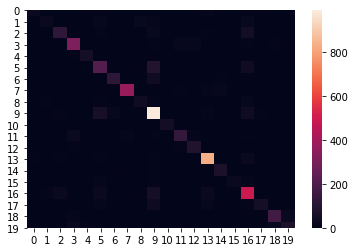

[0.71746085 0.71830274 0.7333221  0.72445194 0.72185654]
0.7230788356734159
-----


In [0]:
train(train_rep1, processed_train_target)

# Experimenting with Variants of Feature Generation

* TF-IDF
* Lemmatization (inspired by : https://www.kaggle.com/longyg/svc-classification)
* Word2Vec


In [0]:
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

# Varying n-grams
print("1-gram")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1,
                                                 use_idf=True, smooth_idf=True, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

print("3-gram")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=3,
                                                 use_idf=True, smooth_idf=True, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

# Varying n-grams
print("binary")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=True, ngrammax=2,
                                                 use_idf=True, smooth_idf=True, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

print("Non-smooth IDF")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

print("Sublinear_TF")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=True, sublinear_tf=True)
train(train_rep, processed_train_target, False, False)

print("No-DF")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=False, smooth_idf=True, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

Logistic
RFC LogLoss 0.8616560085433441
RFC Accuracy 0.7534442805982726
RFC Accuracy 0.7219413549039434
-----
1-gram
Logistic
RFC LogLoss 0.8848051777134502
RFC Accuracy 0.739709290077944
RFC Accuracy 0.7253117627232896
-----
3-gram
Logistic
RFC LogLoss 0.8632833899999495
RFC Accuracy 0.7507057088687592
RFC Accuracy 0.7180653859116953
-----
binary
Logistic
RFC LogLoss 0.8591607509394944
RFC Accuracy 0.7520539287971351
RFC Accuracy 0.7263228850690934
-----
Non-smooth IDF
Logistic
RFC LogLoss 0.8554747670276479
RFC Accuracy 0.7539498630714135
RFC Accuracy 0.7126727334007414
-----
Sublinear_TF
Logistic
RFC LogLoss 0.858280091617357
RFC Accuracy 0.7520960606698968
RFC Accuracy 0.7229524772497472
-----
No-DF
Logistic
RFC LogLoss 0.9032963709511864
RFC Accuracy 0.7411417737518433
RFC Accuracy 0.7221098752949107
-----


In [0]:
print("Heursitic best")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)
train(train_rep, processed_train_target, True, False)

Heursitic best
Logistic
RFC LogLoss 0.8576925926689545
RFC Accuracy 0.7532757531072256
RFC Accuracy 0.7210987529491069
[0.71931302 0.71998653 0.73113208 0.72310287 0.71881857]
0.7224706106059282
-----


In [0]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
def stem_vec(train_bin_vec, stemtype=0):
    if stemtype == 0:
        stemmer = PorterStemmer()
    else:
        stemmer = LancasterStemmer()

    stem_dat = []
    for dat in train_bin_vec:
        stem_txt = []
        for w in dat[-1].split():
            stem_txt.append(stemmer.stem(w))
        stem_dat.append([' '.join(stem_txt)])
    return stem_dat

def lemmatize_vec(train_bin_vec):
    lemmatizer = WordNetLemmatizer()
    lem_dat = []
    for dat in train_bin_vec:
        stem_txt = []
        for w in dat[-1].split():
            stem_txt.append(lemmatizer.lemmatize(w))
        lem_dat.append([' '.join(stem_txt)])
    return lem_dat

Tokenization and Lemmetizing doesn't really affect performance

In [0]:
print("Stemming Porter")
stemmed_dat = stem_vec(processed_train_features, 0)
train_rep, test_rep, binarizer = generate_tf_idf(stemmed_dat, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)
train(train_rep, processed_train_target, True, False)

print("Stemming Lancaster")
stemmed_dat = stem_vec(processed_train_features, 1)
train_rep, test_rep, binarizer = generate_tf_idf(stemmed_dat, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)
train(train_rep, processed_train_target, True, False)

print("Lemmatize")
lemmed_dat = lemmatize_vec(processed_train_features)
train_rep, test_rep, binarizer = generate_tf_idf(stemmed_dat, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)
train(train_rep, processed_train_target, True, False)

Stemming Porter
Logistic
RFC LogLoss 0.8482931617382061
RFC Accuracy 0.7546239730356015
RFC Accuracy 0.723963599595551
[0.71796599 0.72419599 0.73365903 0.72023609 0.72253165]
0.7237177486080528
-----
Stemming Lancaster
Logistic
RFC LogLoss 0.8445472719989728
RFC Accuracy 0.7579523909837792
RFC Accuracy 0.7165487023929895
[0.71796599 0.72604816 0.73433288 0.72192243 0.72067511]
0.7241889123416083
-----
Lemmatize
Logistic
RFC LogLoss 0.8427042074075547
RFC Accuracy 0.7562671160733094
RFC Accuracy 0.7108190091001011
[0.71796599 0.72604816 0.73433288 0.72192243 0.72067511]
0.7241889123416083
-----


In [0]:
print("Heursitic best")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)
train(train_rep, processed_train_target, True, False)

Logistic


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


RFC LogLoss 0.8639955848268829
RFC Accuracy 0.7479671371392458
RFC Accuracy 0.7317155375800471


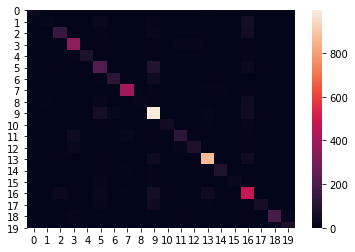

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[0.71998653 0.71796599 0.73180593 0.72462057 0.71983122]
0.722842048832489
-----


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [48]:
def merge_representation(train_features, vectorized_text):
    merged_dat = []
    for i in range(len(train_features)):
        merged_dat.append(np.concatenate((np.array(train_features[i][:-1]), vectorized_text[i])))
    return np.array(merged_dat)

train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)

train_rep = merge_representation(processed_train_features, train_rep.toarray())
train(train_rep, processed_train_target, True, True)

In [0]:
from gensim.models import word2vec

* Compare different models (search hyper-params)
* Dimensionality reduction and different clustering methods

### Download word2vec and generate representation based on that


In [0]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-12-01 18:15:19--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.81.91
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.81.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  13.1MB/s    in 2m 1s   

2019-12-01 18:17:21 (13.0 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
from gensim.models import KeyedVectors

In [0]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def cos(x1, x2):
  return np.dot(x1, x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))
print(cos(word2vec["salt"], word2vec["pepper"]))
print(cos(word2vec["meat"], word2vec["steak"]))
print(cos(word2vec["lettuce"], word2vec["steak"]))
print(cos(word2vec["lettuce"], word2vec["cabbage"]))

0.4258557
0.5724613
0.37770718
0.6451551


In [0]:
def generate_word2vec(train_bin_vec):
    word2vec_rep = []
    for dat in train_bin_vec:
        vec = np.zeros(300)
        for w in dat[-1]:
            if w in word2vec:
                vec += word2vec[w]
        word2vec_rep.append(vec)
    return np.array(word2vec_rep)

In [0]:
word_rep = generate_word2vec(processed_train_features)

In [0]:
print(word_rep.shape)

(39559, 300)


In [0]:
# I have a downloaded copy of this file
np.savetxt("word2vec.txt", word_rep)

Logistic


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


RFC LogLoss 1.8055014288302476
RFC Accuracy 0.4565409732462608
RFC Accuracy 0.448938321536906


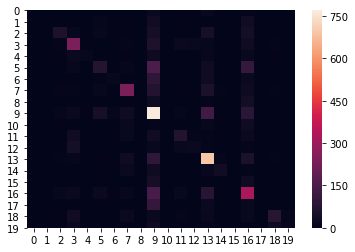

-----


In [47]:
train(word_rep, processed_train_target, False, True)

Logistic


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


RFC LogLoss 1.4645176551057728
RFC Accuracy 0.5730777333052455
RFC Accuracy 0.5569598921469497


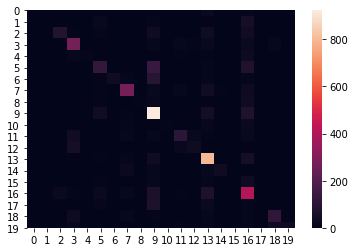

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[0.58595723 0.58679912 0.543969   0.59443508 0.56624473]
0.5754810321216162
-----


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [53]:
def merge_word2vec(train_rep_old, word2vec_rep):
    merged_dat = []
    for i in range(len(train_rep_old)):
        merged_dat.append(np.concatenate((np.array(train_rep_old[i]), word2vec_rep[i])))
    return np.array(merged_dat)

train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)

train_rep = merge_representation(processed_train_features, train_rep.toarray())
train_rep2 = merge_word2vec(train_rep, word_rep)

train(train_rep2, processed_train_target, True, True)